In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageSequence
import imageio

In [4]:
def load_images(folder, type):
    images = []
    for img_file in os.listdir(folder):
        if type in ['mask', 'output']:
            # Extract frames from the GIF image
            gif_image = Image.open(os.path.join(folder, img_file))
            if gif_image is not None:
                grayscale_frames = []
                for frame in ImageSequence.Iterator(gif_image):
                    frame_gray = frame.convert('L')
                    grayscale_frames.append(np.array(frame_gray))

                images.append(np.array(grayscale_frames))
        else:
            load_img = cv2.imread(os.path.join(folder, img_file))
            if load_img is not None:
                load_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
                images.append(load_img)
    
    return images

In [5]:
train_imgs = load_images("./DRIVE/training/images", "input")
output_imgs = load_images("./DRIVE/training/1st_manual", 'output')
mask_imgs = load_images("./DRIVE/training/mask", 'mask')

In [6]:

def preprocess_image(image, mask, threshold=200):
    
    # Extract the inverted green channel
    inv_green_channel = 255 - image[:, :, 1]
    
    # Apply a 69x69 mean filter to compute the local average
    local_avg = cv2.blur(inv_green_channel, (69, 69))
    
    # Select regions with values greater than threshold
    bright_mask = inv_green_channel > threshold

    # Replace bright regions with the local average background
    inv_green_channel[bright_mask] = local_avg[bright_mask]
 
    # Subtract the local background and scale the gray levels from 0 to 1
    subtracted = inv_green_channel.astype(np.float32) - local_avg.astype(np.float32)
    subtracted_scaled = cv2.normalize(subtracted, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # Add a constant so that the mode gray level value is set to 0.5
    # This is an approximation using a histogram to find the mode
    hist, bins = np.histogram(subtracted_scaled.flatten(), 256, [0,1])
    mode = bins[np.argmax(hist)] 
    adjusted_image = subtracted_scaled + (0.5 - mode)
    
    adjusted_image = cv2.bitwise_and(adjusted_image, adjusted_image, mask=mask)
    
    return adjusted_image

A function that returns structuring elements of desired radius.

In [7]:
def create_structuring_element(radius):
    diameter = 2 * radius + 1

    x = np.arange(diameter).reshape(1, -1)
    y = np.arange(diameter).reshape(-1, 1)
    element = (x - radius)**2 + (y - radius)**2 <= radius**2

    return element.astype(np.uint8)

A function that implements the tophat operation. It is given as:
$$tophat(img) = img - min(open(close(img, W_c), W), img)$$
where 
$$
\begin{align*}
&W_c = \text{structuring element of radius 2 pixels} \\
&W = \text{structuring element of radius varying from 1 to 8 pixels}
\end{align*}
$$

In [8]:
def tophat(img, Wc_radius, W_radii):
    # create structuring element for closing operation
    kernel_close = create_structuring_element(Wc_radius)
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)

    tophat_imgs = []

    for W_rad in W_radii:
        kernel_open = create_structuring_element(W_rad)
        open_img = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel_open)

        tophat_img = img - cv2.min(open_img, img)
        tophat_imgs.append(tophat_img)
    # an array of 4 images
    # return closed_img, tophat_imgs
    average_tophat_imgs =  [((i + 1) * tophat_imgs[i] + (i + 2) * tophat_imgs[i + 1]) / 2 for i in range(0, len(tophat_imgs), 2)]
    # average_tophat_imgs = [(np.add(tophat_imgs[i], tophat_imgs[i + 1]) / 2).astype(int) for i in range(0, len(tophat_imgs), 2)]

    max_tophat_img = np.zeros_like(average_tophat_imgs[0], dtype = np.float64)

    for i, tophat_img in enumerate(average_tophat_imgs):
        max_tophat_img = np.maximum(max_tophat_img, tophat_img)
        # weight = (W_radii[-1] - i) / W_radii[-1]
        # max_tophat_img += tophat_img
    normalised_img = cv2.normalize(max_tophat_img, None, 0, 1, cv2.NORM_MINMAX)

    return normalised_img

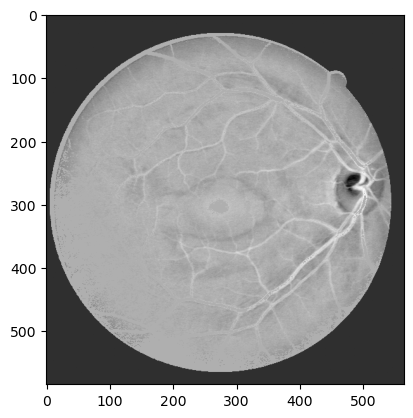

In [9]:
plt.imshow(preprocess_image(train_imgs[0], np.squeeze(mask_imgs[0], axis = 0)), cmap = 'gray')

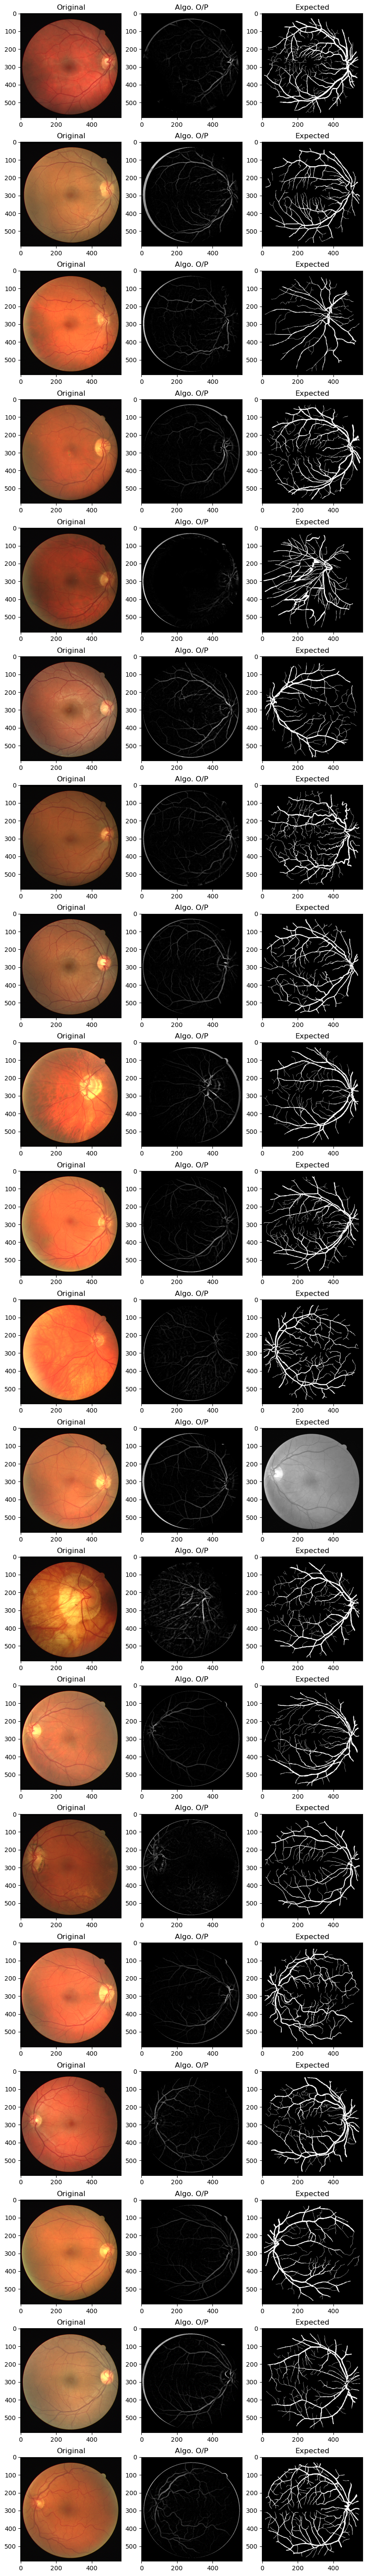

In [10]:
Wc_radius = 2
W_radii = np.arange(1, 9)
fig, axes = plt.subplots(20, 3, figsize = (10, 75))
for i, img in enumerate(train_imgs):
    top_img = tophat(preprocess_image(img, np.squeeze(mask_imgs[i], axis = 0)), Wc_radius, W_radii)
    axes[i, 0].imshow(img, cmap = 'gray')
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(top_img, cmap = 'gray')
    axes[i, 1].set_title('Algo. O/P')
    axes[i, 2].imshow(np.squeeze(output_imgs[i], axis = 0), cmap = 'gray')
    axes[i, 2].set_title('Expected')